In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torchsummary import summary
from utils import train, test, plot_stats, PlotOutput, get_device
from tqdm import tqdm

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from models.david_page import DavidPageNet

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
device = get_device()
device

'cuda'

In [3]:
# augmentations
# x = datasets.CIFAR10(root='./data', train=True, download=True)

mean = [0.49139968, 0.48215841, 0.44653091] # (x.data.transpose() / 255).reshape(3,-1).mean(-1)
std = [0.24703223, 0.24348513, 0.26158784] # (x.data.transpose() / 255).reshape(3,-1).std(-1)

train_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        A.ToGray(p=0.2),
        A.PadIfNeeded(40, 40, p=1),
        A.RandomCrop(32, 32, p=1),
        A.HorizontalFlip(p=0.5),
        A.CoarseDropout(max_holes=1, max_height=8, max_width=8, fill_value=0, p=1),
        A.Resize(32, 32),
        ToTensorV2()
    ]
)

test_transform = A.Compose(
    [
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ]
)

In [4]:
from PIL import Image

class ACIFAR10(datasets.CIFAR10):
    def __init__(self, **kwargs):
        super(ACIFAR10, self).__init__(**kwargs)
    
    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        
        if self.transform is not None:
            img = self.transform(image=img)["image"]
        
        return img, target

In [5]:
# datasets
trainset = ACIFAR10(
    root='./data', train=True, download=True, transform=train_transform)

testset = ACIFAR10(
    root='./data', train=False, download=True, transform=test_transform)

# dataloaders
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(
    testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


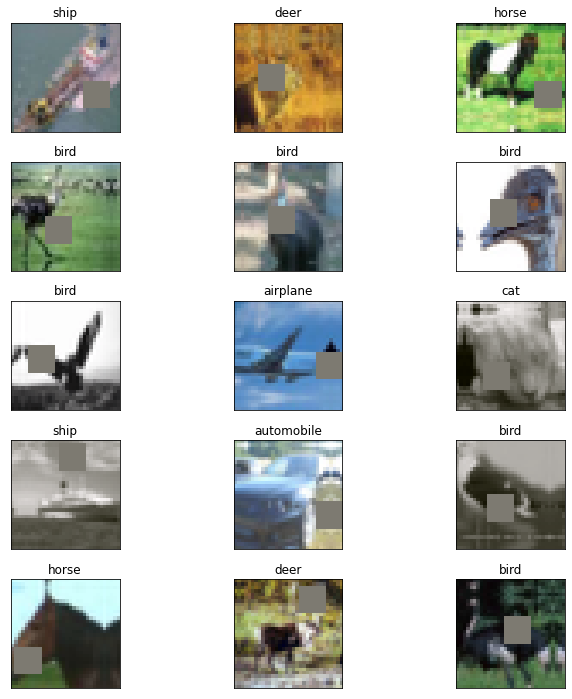

In [6]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(10, 10))
batch_data, batch_label = next(iter(train_loader))

t_std = torch.tensor(std).reshape(3, 1, 1)
t_mean = torch.tensor(mean).reshape(3, 1, 1)


for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.tight_layout()

    # get an image - [3, 32, 32]
    # and denormalize
    image = batch_data[i] * t_std + t_mean

    # Clip the input data to the valid range [0, 1]
    image = image.clip(0, 1)
    
    # [3, 32, 32] to [32, 32, 3]
    image = image.permute(1, 2, 0)
    plt.imshow(image)
    
    plt.title(classes[batch_label[i].item()])
    plt.xticks([])
    plt.yticks([])

In [9]:
model = DavidPageNet(dropout=0.).to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
          Identity-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,456
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,456
      BatchNorm2d-14          [-1, 128,

In [10]:
criterion = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.01)

/home/qblocks/.local/lib/python3.8/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.83E-02


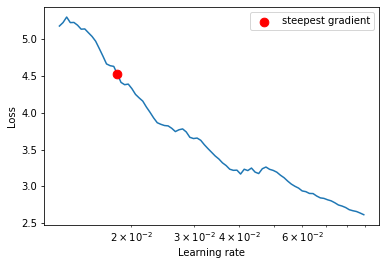

In [11]:
from torch_lr_finder import LRFinder

EPOCHS = 24

def find_lr():
    lr_finder = LRFinder(model, optimizer, criterion, device=device)
    lr_finder.range_test(train_loader, end_lr=0.1, num_iter=100, step_mode='exp')
    
    _, best_lr = lr_finder.plot()
    lr_finder.reset()
    
    return best_lr 


scheduler = optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=find_lr(),
            steps_per_epoch=len(train_loader),
            epochs=EPOCHS,
            pct_start=5 / EPOCHS,
            div_factor=100,
            three_phase=False,
            final_div_factor=100,
            anneal_strategy='linear'
        )

In [13]:
EPOCH = 24


for _ in range(EPOCH):
    print(f"Epoch: {_+1} Last LR: {scheduler.get_last_lr()[0]}")
    
    train(model, device, train_loader, optimizer, criterion, scheduler)
    test(model, device, test_loader, criterion)

Epoch: 1 Last LR: 0.00018307382802953682


Train: Loss=1.1737 Batch_id=1562 Accuracy=51.04: 100%|██████████| 1563/1563 [00:21<00:00, 72.96it/s]


Test set: Average loss: 1.1163, Accuracy: 6206/10000 (62.06%)

Epoch: 2 Last LR: 0.0038083995162566213


Train: Loss=0.7637 Batch_id=1562 Accuracy=65.78: 100%|██████████| 1563/1563 [00:21<00:00, 73.82it/s]


Test set: Average loss: 0.8009, Accuracy: 7256/10000 (72.56%)

Epoch: 3 Last LR: 0.007433725204483706


Train: Loss=0.8228 Batch_id=1562 Accuracy=69.96: 100%|██████████| 1563/1563 [00:21<00:00, 72.33it/s]


Test set: Average loss: 0.7066, Accuracy: 7584/10000 (75.84%)

Epoch: 4 Last LR: 0.011059050892710792


Train: Loss=1.0066 Batch_id=1562 Accuracy=70.49: 100%|██████████| 1563/1563 [00:21<00:00, 71.35it/s]


Test set: Average loss: 0.7893, Accuracy: 7416/10000 (74.16%)

Epoch: 5 Last LR: 0.014684376580937875


Train: Loss=0.8486 Batch_id=1562 Accuracy=70.84: 100%|██████████| 1563/1563 [00:21<00:00, 72.75it/s]


Test set: Average loss: 0.7942, Accuracy: 7400/10000 (74.00%)

Epoch: 6 Last LR: 0.018306766392135597


Train: Loss=1.2099 Batch_id=1562 Accuracy=71.52: 100%|██████████| 1563/1563 [00:21<00:00, 72.22it/s]


Test set: Average loss: 0.6851, Accuracy: 7663/10000 (76.63%)

Epoch: 7 Last LR: 0.01734331628346858


Train: Loss=0.7181 Batch_id=1562 Accuracy=74.26: 100%|██████████| 1563/1563 [00:21<00:00, 72.11it/s]


Test set: Average loss: 0.6163, Accuracy: 7958/10000 (79.58%)

Epoch: 8 Last LR: 0.01637986617480156


Train: Loss=0.6092 Batch_id=1562 Accuracy=76.14: 100%|██████████| 1563/1563 [00:20<00:00, 74.98it/s]


Test set: Average loss: 0.5662, Accuracy: 8088/10000 (80.88%)

Epoch: 9 Last LR: 0.015416416066134538


Train: Loss=0.8787 Batch_id=1562 Accuracy=77.91: 100%|██████████| 1563/1563 [00:21<00:00, 73.54it/s]


Test set: Average loss: 0.4848, Accuracy: 8355/10000 (83.55%)

Epoch: 10 Last LR: 0.014452965957467517


Train: Loss=0.6554 Batch_id=1562 Accuracy=79.26: 100%|██████████| 1563/1563 [00:21<00:00, 74.41it/s]


Test set: Average loss: 0.5100, Accuracy: 8316/10000 (83.16%)

Epoch: 11 Last LR: 0.013489515848800496


Train: Loss=0.3597 Batch_id=1562 Accuracy=80.55: 100%|██████████| 1563/1563 [00:21<00:00, 72.08it/s]


Test set: Average loss: 0.4407, Accuracy: 8503/10000 (85.03%)

Epoch: 12 Last LR: 0.012526065740133475


Train: Loss=0.5401 Batch_id=1562 Accuracy=82.12: 100%|██████████| 1563/1563 [00:22<00:00, 70.29it/s]


Test set: Average loss: 0.4251, Accuracy: 8631/10000 (86.31%)

Epoch: 13 Last LR: 0.011562615631466456


Train: Loss=0.6236 Batch_id=1562 Accuracy=83.04: 100%|██████████| 1563/1563 [00:21<00:00, 72.97it/s]


Test set: Average loss: 0.4051, Accuracy: 8638/10000 (86.38%)

Epoch: 14 Last LR: 0.010599165522799435


Train: Loss=0.3239 Batch_id=1562 Accuracy=84.14: 100%|██████████| 1563/1563 [00:22<00:00, 70.59it/s]


Test set: Average loss: 0.3868, Accuracy: 8721/10000 (87.21%)

Epoch: 15 Last LR: 0.009635715414132414


Train: Loss=0.1610 Batch_id=1562 Accuracy=85.21: 100%|██████████| 1563/1563 [00:20<00:00, 74.89it/s]


Test set: Average loss: 0.3803, Accuracy: 8756/10000 (87.56%)

Epoch: 16 Last LR: 0.008672265305465394


Train: Loss=0.2477 Batch_id=1562 Accuracy=85.96: 100%|██████████| 1563/1563 [00:21<00:00, 73.21it/s]


Test set: Average loss: 0.3482, Accuracy: 8857/10000 (88.57%)

Epoch: 17 Last LR: 0.0077088151967983735


Train: Loss=0.6937 Batch_id=1562 Accuracy=86.74: 100%|██████████| 1563/1563 [00:21<00:00, 73.86it/s]


Test set: Average loss: 0.3343, Accuracy: 8869/10000 (88.69%)

Epoch: 18 Last LR: 0.006745365088131354


Train: Loss=0.5262 Batch_id=1562 Accuracy=87.62: 100%|██████████| 1563/1563 [00:20<00:00, 74.70it/s]


Test set: Average loss: 0.3379, Accuracy: 8909/10000 (89.09%)

Epoch: 19 Last LR: 0.005781914979464332


Train: Loss=0.2550 Batch_id=1562 Accuracy=88.59: 100%|██████████| 1563/1563 [00:21<00:00, 73.46it/s]


Test set: Average loss: 0.2975, Accuracy: 9052/10000 (90.52%)

Epoch: 20 Last LR: 0.0048184648707973125


Train: Loss=0.0943 Batch_id=1562 Accuracy=89.14: 100%|██████████| 1563/1563 [00:21<00:00, 72.75it/s]


Test set: Average loss: 0.2828, Accuracy: 9068/10000 (90.68%)

Epoch: 21 Last LR: 0.0038550147621302915


Train: Loss=0.3190 Batch_id=1562 Accuracy=90.04: 100%|██████████| 1563/1563 [00:21<00:00, 73.08it/s]


Test set: Average loss: 0.2855, Accuracy: 9080/10000 (90.80%)

Epoch: 22 Last LR: 0.0028915646534632723


Train: Loss=0.2362 Batch_id=1562 Accuracy=90.48: 100%|██████████| 1563/1563 [00:20<00:00, 76.35it/s]


Test set: Average loss: 0.2694, Accuracy: 9112/10000 (91.12%)

Epoch: 23 Last LR: 0.0019281145447962514


Train: Loss=0.1208 Batch_id=1562 Accuracy=91.06: 100%|██████████| 1563/1563 [00:21<00:00, 71.87it/s]


Test set: Average loss: 0.2638, Accuracy: 9141/10000 (91.41%)

Epoch: 24 Last LR: 0.0009646644361292304


Train: Loss=0.1727 Batch_id=1562 Accuracy=91.80: 100%|██████████| 1563/1563 [00:21<00:00, 72.81it/s]


Test set: Average loss: 0.2612, Accuracy: 9154/10000 (91.54%)



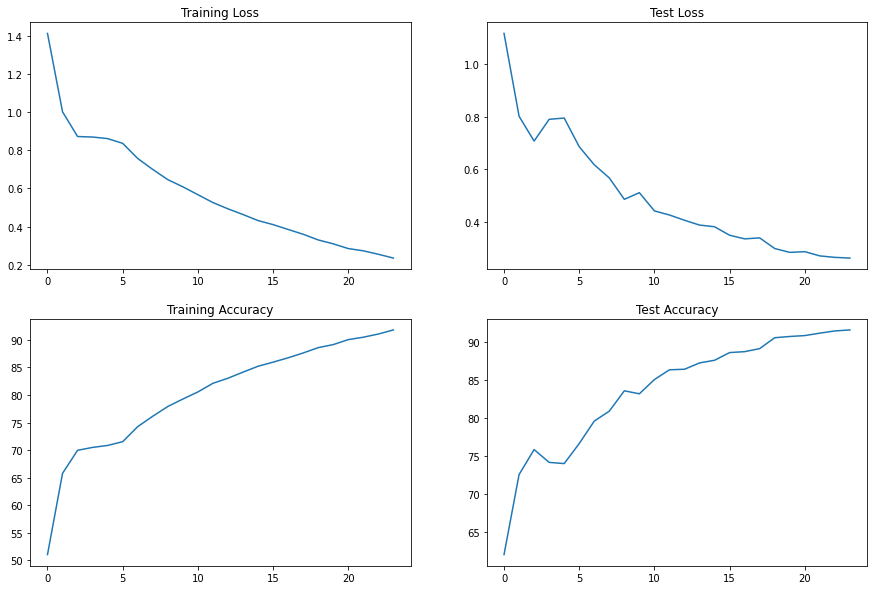

In [16]:
plot_stats()

100%|██████████| 313/313 [00:02<00:00, 143.82it/s]


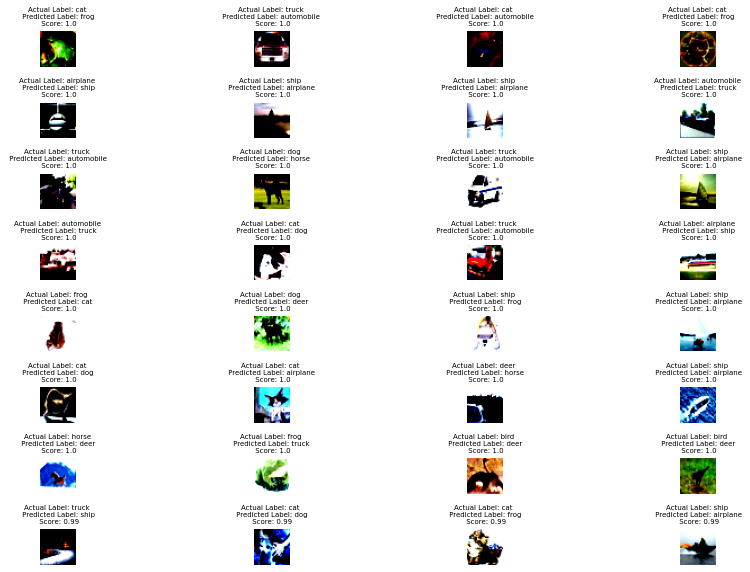

In [20]:
# plot incorrect plus very difficult classifications
p = PlotOutput(device)
p.run_prediction(model, test_loader, class_list=classes, ptype="incorrect")
p.plot(n=32, reverse=True)

100%|██████████| 313/313 [00:02<00:00, 133.17it/s]


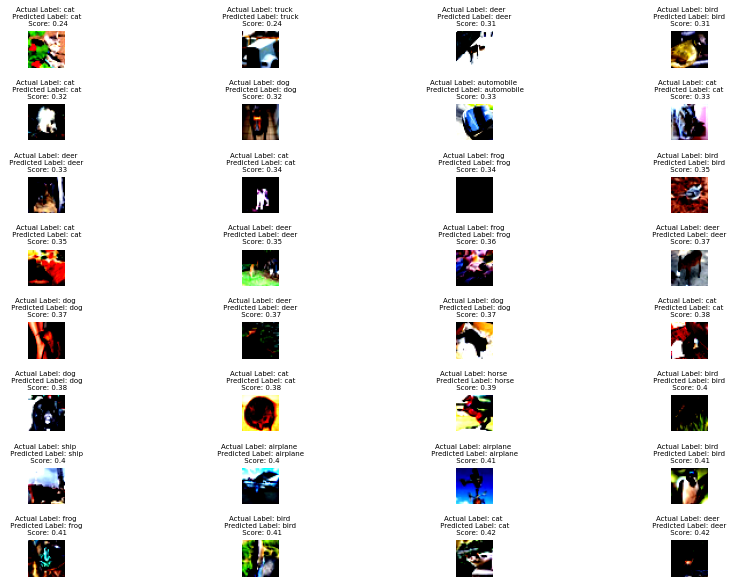

In [21]:
# plot correct yet difficult classifications
p.run_prediction(model, test_loader, class_list=classes, ptype="correct")
p.plot(n=32, reverse=False)